<a href="https://colab.research.google.com/github/onurercen/workout_prediction_app/blob/main/RF_Experience_Level_FIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest - Experience Level Prediction

**Standart Ayarlar:** test_size=0.30, random_state=42, cv=5

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print('Kütüphaneler yüklendi.')

Kütüphaneler yüklendi.


In [2]:
# Veri yükleme
df = pd.read_csv('gym_members_exercise_tracking.csv')
print('='*70)
print('RANDOM FOREST - EXPERIENCE LEVEL PREDICTION')
print('='*70)
print(f'Veri seti boyutu: {df.shape}')

RANDOM FOREST - EXPERIENCE LEVEL PREDICTION
Veri seti boyutu: (973, 15)


In [3]:
# FEATURE ENGINEERING
df['HR_per_minute'] = df['Avg_BPM'] / (df['Session_Duration (hours)'] * 60)
df['Intensity_per_Weight'] = df['Calories_Burned'] / df['Weight (kg)']
df['HRR'] = df['Max_BPM'] - df['Resting_BPM']
df['Efficiency'] = df['Calories_Burned'] / df['Avg_BPM']
df['Anaerobic_Index'] = (df['Max_BPM'] - df['Avg_BPM']) / df['Resting_BPM']
df['BPM_Variance_Rest'] = (df['Avg_BPM'] - df['Resting_BPM']) ** 2
df['Heart_Instability'] = abs(df['Max_BPM'] - df['Avg_BPM']) / df['Max_BPM']
df['Calories_per_Hour'] = df['Calories_Burned'] / df['Session_Duration (hours)']
df['Heart_Efficiency'] = df['Calories_Burned'] / df['HRR']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)
df['Workout_Intensity'] = df['Calories_Burned'] * df['Max_BPM'] / 1000
df['Performance_Score'] = df['Calories_Burned'] * df['Workout_Frequency (days/week)']
df['Fitness_Level'] = df['HRR'] / df['Resting_BPM']
df['Training_Load'] = df['Session_Duration (hours)'] * df['Workout_Frequency (days/week)'] * df['Avg_BPM']
print('15 yeni feature oluşturuldu')

15 yeni feature oluşturuldu


In [4]:
# Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()
df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Workout_Type_Encoded'] = le_workout.fit_transform(df['Workout_Type'])

In [5]:
# Feature seçimi
feature_cols = [
    'Age', 'Gender_Encoded', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Type_Encoded', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability',
    'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group',
    'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load'
]
X = df[feature_cols]
y = df['Experience_Level']
print(f'Feature sayısı: {X.shape[1]}')

Feature sayısı: 29


In [6]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

Train: 681, Test: 292


In [7]:
# Baseline
print('\n' + '='*70)
print('BASELINE MODEL')
print('='*70)
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)
print(f'Train: {accuracy_score(y_train, rf_baseline.predict(X_train)):.4f}')
print(f'Test:  {accuracy_score(y_test, rf_baseline.predict(X_test)):.4f}')


BASELINE MODEL
Train: 1.0000
Test:  0.8904


In [9]:
# GridSearchCV
print('\n' + '='*70)
print('HYPERPARAMETER TUNING')
print('='*70)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print(f'\nBest params: {grid_search.best_params_}')
print(f'Best CV: {grid_search.best_score_:.4f}')


HYPERPARAMETER TUNING
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV: 0.8796


In [10]:
# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
train_acc = accuracy_score(y_train, best_model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f'\nTrain: {train_acc:.4f}')
print(f'Test:  {test_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Beginner', 'Intermediate', 'Advanced']))


Train: 1.0000
Test:  0.8870

Classification Report:
              precision    recall  f1-score   support

    Beginner       0.90      0.80      0.85       113
Intermediate       0.83      0.92      0.87       122
    Advanced       1.00      1.00      1.00        57

    accuracy                           0.89       292
   macro avg       0.91      0.90      0.91       292
weighted avg       0.89      0.89      0.89       292



In [11]:
# CV
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f'CV Mean: {cv_scores.mean():.4f}')

CV Mean: 0.8796


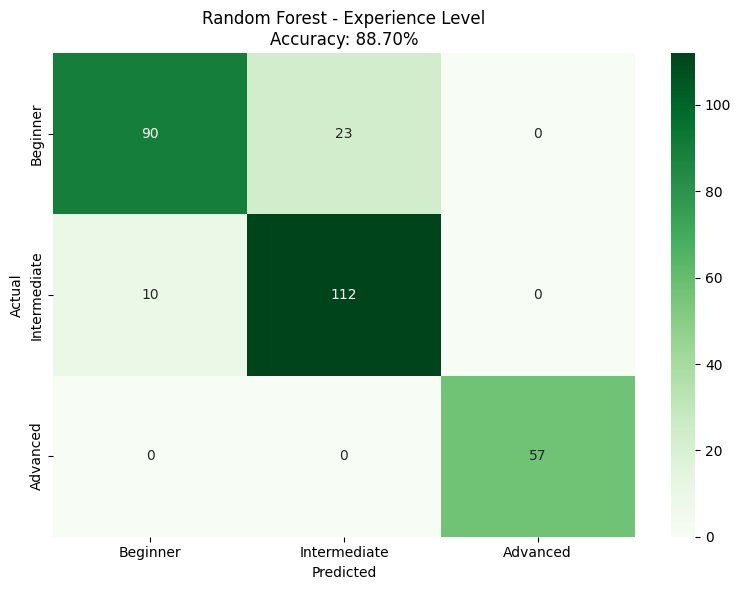

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Beginner', 'Intermediate', 'Advanced'], yticklabels=['Beginner', 'Intermediate', 'Advanced'])
plt.title(f'Random Forest - Experience Level\nAccuracy: {test_acc:.2%}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('rf_exp_confusion_matrix.png', dpi=150)
plt.show()

Top 10:
                      Feature  Importance
     Session_Duration (hours)    0.148016
                Training_Load    0.142093
            Performance_Score    0.134945
               Fat_Percentage    0.119619
Workout_Frequency (days/week)    0.105552
                   Efficiency    0.059289
                HR_per_minute    0.044781
              Calories_Burned    0.039615
            Workout_Intensity    0.030042
             Heart_Efficiency    0.024894


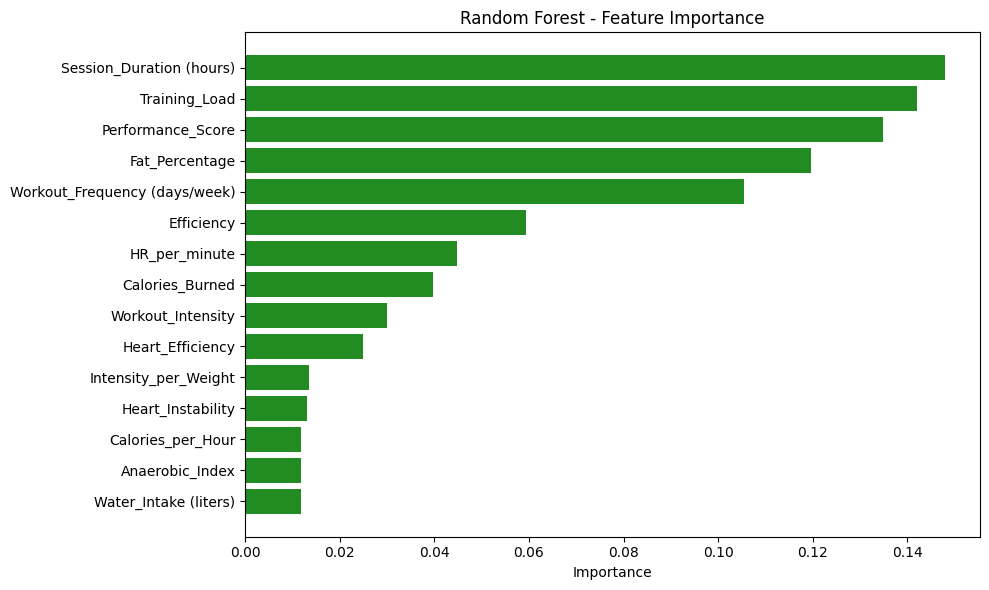

In [13]:
# Feature Importance
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': best_model.feature_importances_}).sort_values('Importance', ascending=False)
print('Top 10:')
print(importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['Importance'], color='forestgreen')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance')
plt.title('Random Forest - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rf_exp_feature_importance.png', dpi=150)
plt.show()

In [14]:
print('\n' + '='*70)
print('MODEL ÖZETİ')
print('='*70)
print(f'Train: {train_acc:.4f}, Test: {test_acc:.4f}, CV: {cv_scores.mean():.4f}')


MODEL ÖZETİ
Train: 1.0000, Test: 0.8870, CV: 0.8796


In [16]:
# ======================================================
# REGULARIZED RANDOM FOREST (OVERFITTING AZALTMA)
# ======================================================

print('\n' + '='*70)
print('REGULARIZED RANDOM FOREST')
print('='*70)

rf_regularized = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=1
)

rf_regularized.fit(X_train, y_train)

train_reg = accuracy_score(y_train, rf_regularized.predict(X_train))
test_reg  = accuracy_score(y_test, rf_regularized.predict(X_test))
cv_reg    = cross_val_score(rf_regularized, X_train, y_train, cv=5).mean()

print(f'Train: {train_reg:.4f}')
print(f'Test:  {test_reg:.4f}')
print(f'CV:    {cv_reg:.4f}')



REGULARIZED RANDOM FOREST
Train: 0.9736
Test:  0.8938
CV:    0.8678
